## CTA200H Summer School Project: Polarimetry and Faraday Rotation

### Exercise 1: Linear Fit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import astropy.units as unit
import astropy.time as time
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import SpectralCoord
from scipy.optimize import curve_fit

1.)

In [12]:
# Read in raw FITS files and view them
i_raw = fits.open("image.restored.i.SB9945.contcube.13arcsec.fits")
q_raw = fits.open("image.restored.q.SB9945.contcube.13arcsec.fits")
u_raw = fits.open("image.restored.u.SB9945.contcube.13arcsec.fits")

i_raw.info()
q_raw.info()
u_raw.info()

Filename: image.restored.i.SB9945.contcube.13arcsec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   (181, 181, 144, 1)   float32   
Filename: image.restored.q.SB9945.contcube.13arcsec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   (181, 181, 144, 1)   float32   
Filename: image.restored.u.SB9945.contcube.13arcsec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   (181, 181, 144, 1)   float32   


In [13]:
i_head = i_raw[0].header
i_head

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  181                                                  
NAXIS2  =                  181                                                  
NAXIS3  =                  144                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   3.611111111111E-03                                                  
BMIN    =   3.611111111111E-03                                                  
BPA     =   0.000000000000E+

In [14]:
q_head = q_raw[0].header
q_head

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  181                                                  
NAXIS2  =                  181                                                  
NAXIS3  =                  144                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   3.611111111111E-03                                                  
BMIN    =   3.611111111111E-03                                                  
BPA     =   0.000000000000E+

In [15]:
u_head = u_raw[0].header
u_head

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  181                                                  
NAXIS2  =                  181                                                  
NAXIS3  =                  144                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   3.611111111111E-03                                                  
BMIN    =   3.611111111111E-03                                                  
BPA     =   0.000000000000E+

In [17]:
print("Axis 1 corresponds to RA")
print("Axis 2 corresponds to Dec")
print("Axis 3 corresponds to Frequency")
print("Axis 4 corresponds to Stokes")
print(f"Number of frequency channels in each cube: {i_raw[0].header['NAXIS3']}")
print(f"Centre coordinates of image: (RA, Dec) = ({i_raw[0].header['CRVAL1']}, {i_raw[0].header['CRVAL2']}) deg")
print(f"Centre coordinates of image: Frequency = {i_raw[0].header['CRVAL3']} Hz")
print(f"Pixel size in the centre of the image: (RA, Dec) = ({i_raw[0].header['CDELT1']}, {i_raw[0].header['CDELT2']}) deg")
print(f"Stokes Q values have a Stokes value of {q_raw[0].header['CRVAL4']} and Stokes U values have a value of {u_raw[0].header['CRVAL4']}")
print(f"Beam Major: {i_raw[0].header['BMAJ']}")
print(f"Beam Minor: {i_raw[0].header['BMIN']}")
print(f"Beam Position Angle: {i_raw[0].header['BPA']} deg")
print(f"Units of Intensity: {i_raw[0].header['BUNIT']}")




Axis 1 corresponds to RA
Axis 2 corresponds to Dec
Axis 3 corresponds to Frequency
Axis 4 corresponds to Stokes
Number of frequency channels in each cube: 144
Centre coordinates of image: (RA, Dec) = (307.7026, -54.22826111111) deg
Centre coordinates of image: Frequency = 1295990740.741 Hz
Pixel size in the centre of the image: (RA, Dec) = (-0.0005555555555556, 0.0005555555555556) deg
Stokes Q values have a Stokes value of 2.0 and Stokes U values have a value of 3.0
Beam Major: 0.003611111111111
Beam Minor: 0.003611111111111
Beam Position Angle: 0.0 deg
Units of Intensity: Jy/beam


2.)

By looking at the image on DS9, the plumes seem to end and concentrate at the ends. This indicates that the radio galaxy is an FR II.

3.)

In [18]:
q = q_raw[0].data
u = u_raw[0].data
print(f"Shape of Q data: {q.shape}")
print(f"Shape of U data: {u.shape}")

Shape of Q data: (1, 144, 181, 181)
Shape of U data: (1, 144, 181, 181)


In [20]:
# Convert RA, Dec to pixels using WCS
qw = WCS(q_head)
uw = WCS(u_head)
sky1 = SkyCoord(306.695, -55.380, unit="deg")
spec1 = SpectralCoord(1, unit="Hz")
q_ra1, q_dec1 = round(qw.world_to_pixel(sky1, spec1, unit.quantity.Quantity(2))[0]+0),\
    round(qw.world_to_pixel(sky1, spec1, unit.quantity.Quantity(2))[1]+0)
u_ra1, u_dec1 = round(uw.world_to_pixel(sky1, spec1, unit.quantity.Quantity(2))[0]+0),\
    round(uw.world_to_pixel(sky1, spec1, unit.quantity.Quantity(2))[1]+0)

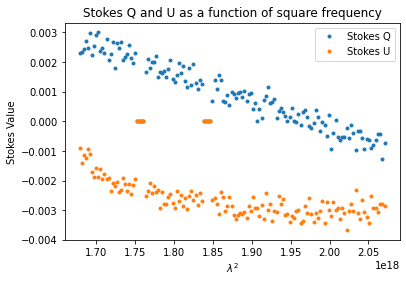

In [10]:
# Plot of Q and U vs lambda^2

# Get the frequency of each channel. Notice that the frequencies for Q and U are identical
freq = qw.pixel_to_world(q_ra1, q_dec1, np.arange(144), 1)[1]

# Select the spectrum at the desired (RA, Dec)
q1 = q[:,:,q_ra1, q_dec1][0]
u1 = u[:,:,u_ra1, u_dec1][0]

plt.figure()
plt.plot(freq**2, q1, label="Stokes Q", ls='', marker='o', ms=3)
plt.plot(freq**2, u1, label="Stokes U", ls='', marker='o', ms=3)
plt.xlabel(r"$\lambda^2$")
plt.ylabel("Stokes Value")
plt.title("Stokes Q and U as a function of square frequency")
plt.legend()

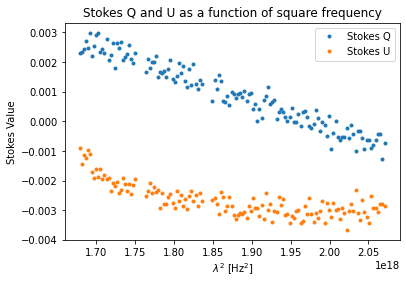

In [242]:
# Remove 0 (missing) values from the plot

plt.figure()
plt.plot(freq[q1 != 0]**2, q1[q1 != 0], label="Stokes Q", ls='', marker='o', ms=3)
plt.plot(freq[u1 != 0]**2, u1[u1 != 0], label="Stokes U", ls='', marker='o', ms=3)
plt.xlabel(r"$\lambda^2$ [Hz$^2$]")
plt.ylabel("Stokes Value")
plt.title("Stokes Q and U as a function of square frequency")
plt.legend()

4.)

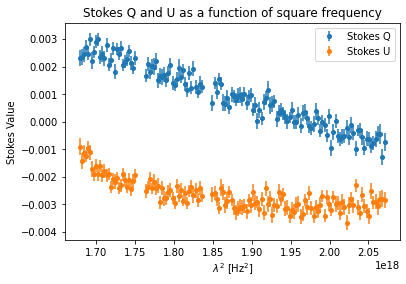

In [243]:
# Get standard deviation for each channel
q_std = []
u_std = []
for i in range(q.shape[1]):
    q_std.append(np.std(q[0,i,0:40,0:40]))
    u_std.append(np.std(u[0,i,0:40,0:40]))
q_std = np.array(q_std)
u_std = np.array(u_std)

plt.figure()
plt.errorbar((freq[q1 != 0]**2).value, q1[q1 != 0], yerr=q_std[q1 != 0], ls='', marker='o', ms=4, label="Stokes Q")
plt.errorbar((freq[u1 != 0]**2).value, u1[u1 != 0], yerr=u_std[u1 != 0], label="Stokes U", ls='', marker='o', ms=4)
plt.xlabel(r"$\lambda^2$ [Hz$^2$]")
plt.ylabel("Stokes Value")
plt.title("Stokes Q and U as a function of square frequency")
plt.legend()

5.)

Text(0.5, 1.0, 'Polarisation intensity and angle as a function of frequency squared')

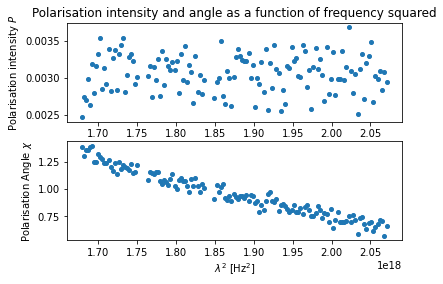

In [268]:
# Polarisation intensity and angle
p1 = np.sqrt(q1[q1 != 0]**2+u1[q1 != 0]**2)
chi1 = np.arctan(u1[q1 != 0]/q1[q1 != 0])/2
for i in range(len(chi1)):
    if chi1[i] < 0:
        chi1[i] = chi1[i]+np.pi/2

# Plots
fig, ax = plt.subplots(2,1)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax[0].plot((freq[u1 != 0]**2).value, p1, ls='', marker='o', ms=4)
ax[0].set_ylabel(r"Polarisation intensity $P$")
ax[1].plot((freq[u1 != 0]**2).value, chi1, ls='', marker='o', ms=4)
ax[1].set_ylabel(r"Polarisation Angle $\chi$")
plt.xlabel(r"$\lambda^2$ [Hz$^2$]")
plt.title("Polarisation intensity and angle as a function of frequency squared")

This source undergoes Faraday rotation because the polarisation angle is linear in frequency squared.

6.)

Since $\sigma_Q\neq\sigma_U$, where $\sigma_Q$ is the error in Stokes Q and $\sigma_U$ is the error in Stokes U, we use $$\sigma_P^2=\frac{Q^2}{||P^2||}\sigma_Q^2+\frac{U^2}{||P^2||}\sigma_U^2$$ for the error in polarisation intensity.

For error in polarisation angle, we use $$\sigma_{\chi}^2=\frac{U^2\sigma_Q^2+Q^2\sigma_U^2}{4||P||^4}.$$

Equations found in Appendix A of arXiv:astro-ph/0507349 (https://www.aanda.org/articles/aa/pdf/2005/39/aa2990-05.pdf) from propagation of error equations.

In [288]:
e_p1 = np.sqrt((q1[q1 != 0]*q_std[q1 != 0]/p1)**2+(u1[u1 != 0]*u_std[u1 != 0]/p1)**2)
e_chi1 = np.sqrt(((u1[u1 != 0]*q_std[q1 != 0])**2+(q1[q1 != 0]*u_std[u1 != 0])**2)/(4*p1**4))

7.)

Text(0.5, 1.0, 'Polarisation intensity and angle as a function of frequency squared')

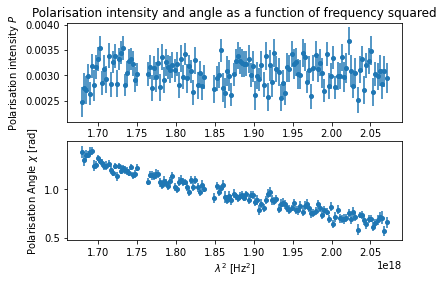

In [300]:
# Plots with errorbars
fig, ax = plt.subplots(2,1)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax[0].errorbar((freq[u1 != 0]**2).value, p1, yerr=e_p1, ls='', marker='o', ms=4)
ax[0].set_ylabel(r"Polarisation intensity $P$")
ax[1].errorbar((freq[u1 != 0]**2).value, chi1, yerr=e_chi1, ls='', marker='o', ms=4)
ax[1].set_ylabel(r"Polarisation Angle $\chi$ [rad]")
plt.xlabel(r"$\lambda^2$ [Hz$^2$]")
plt.title("Polarisation intensity and angle as a function of frequency squared")

8.)

The fitted values are Chi_0 = 4.180613929472435 +/- 0.059041222019888734
And RM = -1.7201068102024276e-18 +/- 3.155582286626464e-20


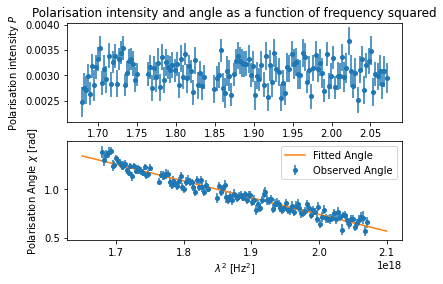

In [334]:
# Solve for chi_0 and RM using scipy curvefit
def far_rot(freq_sq, chi_0, rm):
    return chi_0 + rm * freq_sq

popt, pcov = curve_fit(far_rot, (freq[u1 != 0]**2).value, chi1, sigma=e_chi1,
                       absolute_sigma=True, p0=[4.5, -2])
# Plots with best fit
fig, ax = plt.subplots(2,1)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax[0].errorbar((freq[u1 != 0]**2).value, p1, yerr=e_p1, ls='', marker='o', ms=4)
ax[0].set_ylabel(r"Polarisation intensity $P$")
ax[1].errorbar((freq[u1 != 0]**2).value, chi1, yerr=e_chi1, ls='', marker='o', ms=4, label="Observed Angle")
ax[1].plot(np.linspace(1.65, 2.1, 100) * 10**(18), far_rot(np.linspace(1.65, 2.1, 100) * 10**(18), popt[0], popt[1]), label="Fitted Angle")
ax[1].set_ylabel(r"Polarisation Angle $\chi$ [rad]")
ax[1].legend()
plt.xlabel(r"$\lambda^2$ [Hz$^2$]")
plt.title("Polarisation intensity and angle as a function of frequency squared")

print(f"The fitted values are Chi_0 = {popt[0]} +/- {np.sqrt(np.diag(pcov))[0]}")
print(f"And RM = {popt[1]} +/- {np.sqrt(np.diag(pcov))[1]}")

After fitting the model $$\chi=\chi_0+RM\lambda^2$$ to the data, we find that $$\chi_0=4.18\pm0.06\text{ rad}$$ and $$RM=(-1.72\pm0.03)\times10^{-18}\frac{\text{rad}}{\text{Hz}^2}$$

### Exercise 2: Estimate Lines-of-Sight Magnetic Field Strengths

1.)

If the radio source is located on the line of sight through the cluster centre, $L=200$ kpc because the path through the cluster is the diameter.

2.)

$L=100$ kpc because the path through the cluster is the radius.

3.)
$$B_{||}=\frac{RM}{812n_eL}$$

In [347]:
L1 = 100*unit.kpc
L2 = 200*unit.kpc
n_e = 0.06 * (unit.cm)**(-3)
RM = popt[1] * unit.rad / (unit.Hz)**2
B1 = RM/(812*n_e*L1)
B2 = RM/(812*n_e*L2)
